# Customer Segmentation Using RFM Analysis #
### Introduction
This notebook demonstrates how to segment customers based on their purchasing behavior using RFM (Recency, Frequency, Monetary Value) analysis. 

The goal is to enable targeted marketing campaigns and personalized offers by identifying distinct customer groups with similar purchasing patterns.

## Step 1: Data Loading and Preparation ##

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the data
df = pd.read_csv('D:\internship\customer_segmentation\data\customer_transactions_mock_data.csv')

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15143 entries, 0 to 15142
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    15143 non-null  object 
 1   CustomerID       15143 non-null  object 
 2   TransactionDate  15143 non-null  object 
 3   ProductID        15143 non-null  object 
 4   Quantity         15143 non-null  int64  
 5   UnitPrice        15143 non-null  float64
 6   TotalPrice       15143 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 828.3+ KB
None
  TransactionID CustomerID TransactionDate ProductID  Quantity  UnitPrice  \
0    TRX50000_0   CUST1302      2022-01-12  Prod_107         3      53.74   
1    TRX50000_1   CUST1302      2022-01-12  Prod_104         2      43.15   
2    TRX50000_2   CUST1302      2022-01-12  Prod_107         1      59.80   
3    TRX50001_0   CUST1267      2023-10-17  Prod_108         1     214.31   
4    TRX50001_1   CUST12

### Data Cleaning ###

TransactionID      0
CustomerID         0
TransactionDate    0
ProductID          0
Quantity           0
UnitPrice          0
TotalPrice         0
dtype: int64


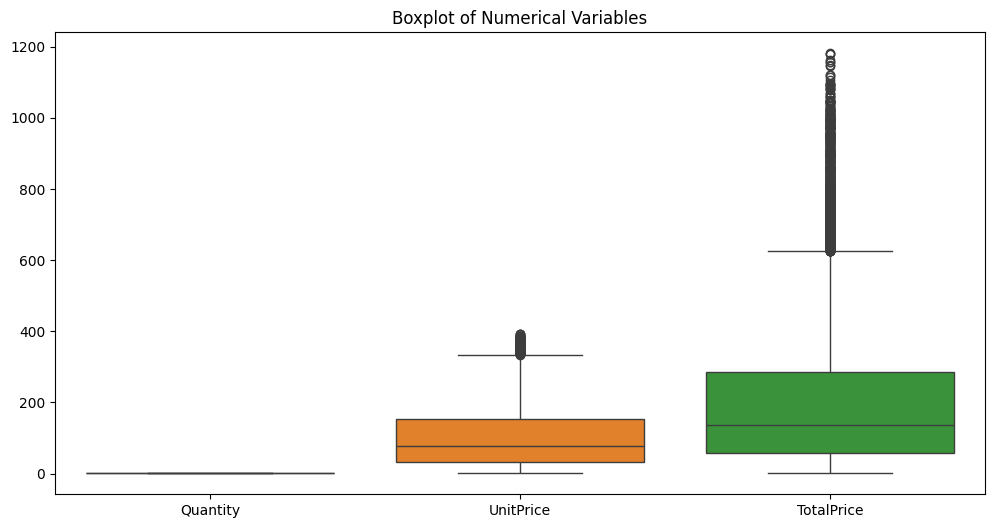

In [3]:
# Check for missing values
print(df.isnull().sum())

# Convert TransactionDate to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Quantity', 'UnitPrice', 'TotalPrice']])
plt.title('Boxplot of Numerical Variables')
plt.show()

## Step 2: RFM Analysis ##
### Calculate RFM Metrics ###

In [4]:
# Set reference date as the day after the last transaction
reference_date = df['TransactionDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (reference_date - x.max()).days,  # Recency
    'TransactionID': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary Value
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(rfm.head())

  CustomerID  Recency  Frequency  Monetary
0   CUST1000        9         41   6855.79
1   CUST1001       49         10   2856.43
2   CUST1002        7         25   2175.73
3   CUST1003       22         33   1085.57
4   CUST1004      134         27   6887.81


## Step 3: Exploratory Data Analysis and Feature Scaling ##
### Analyze RFM Distributions ###

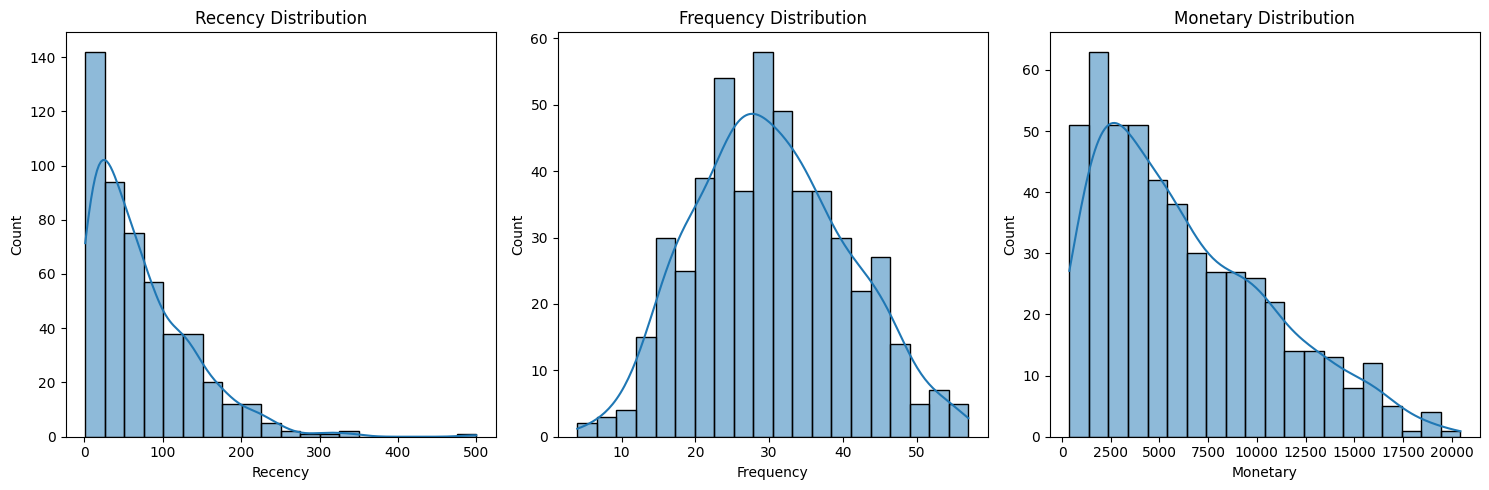

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=20, kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=20, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=20, kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

### Apply Log Transformation and Scaling ###

In [6]:
# Apply log transformation to handle skewness
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log1p(x))

# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled['CustomerID'] = rfm['CustomerID']

print(rfm_scaled.head())

    Recency  Frequency  Monetary CustomerID
0 -1.311601   0.980667  0.458701   CUST1000
1  0.107585  -2.729292 -0.562686   CUST1001
2 -1.508367  -0.347315 -0.880192   CUST1002
3 -0.577150   0.395533 -1.690935   CUST1003
4  0.983425  -0.142103  0.464138   CUST1004


### Analyze RFM Distributions after Log Transformation and Scaling

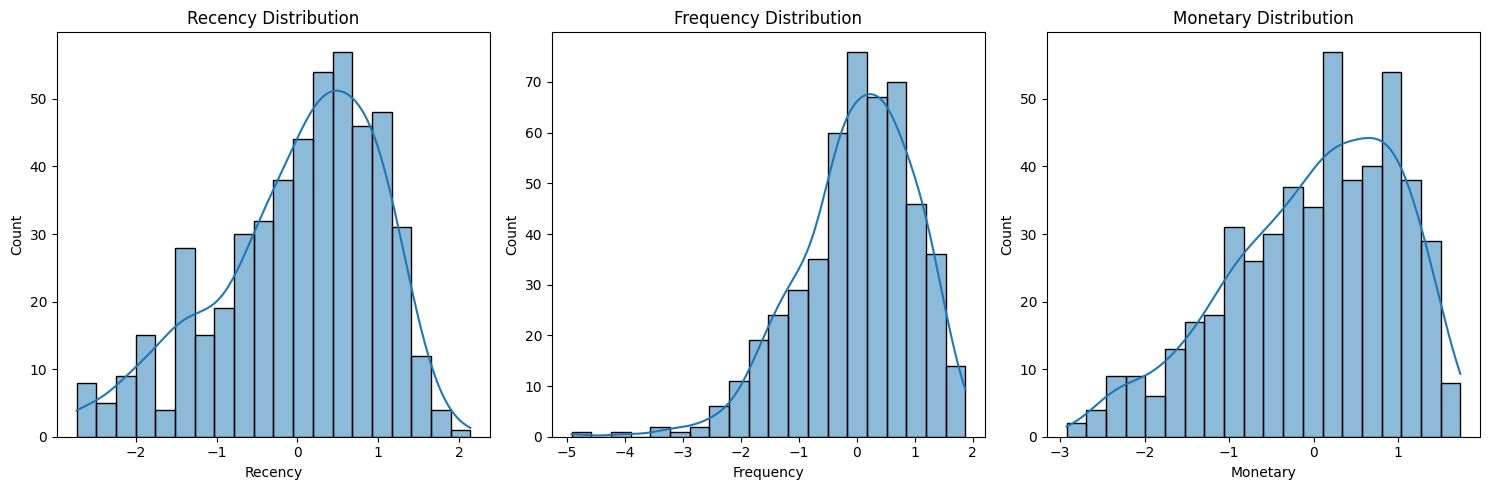

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_scaled['Recency'], bins=20, kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm_scaled['Frequency'], bins=20, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm_scaled['Monetary'], bins=20, kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

## Step 4: Clustering ##
### Determine Optimal Number of Clusters ###

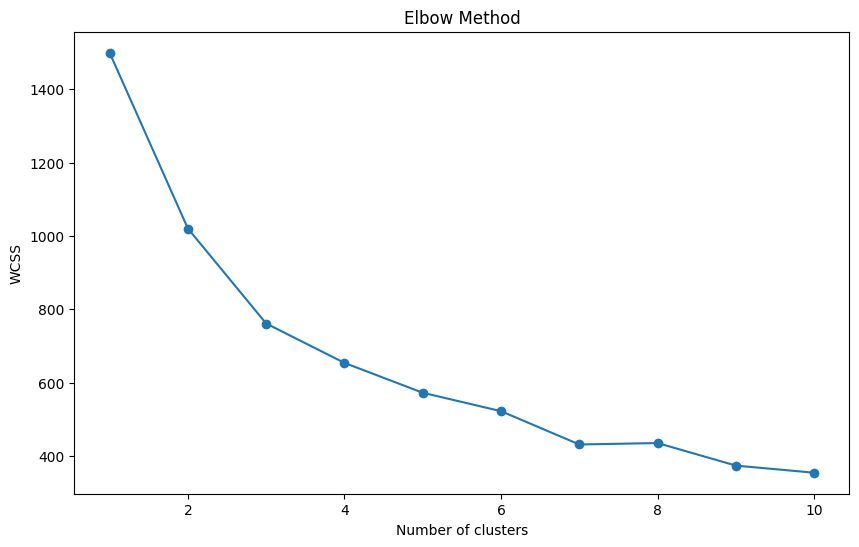

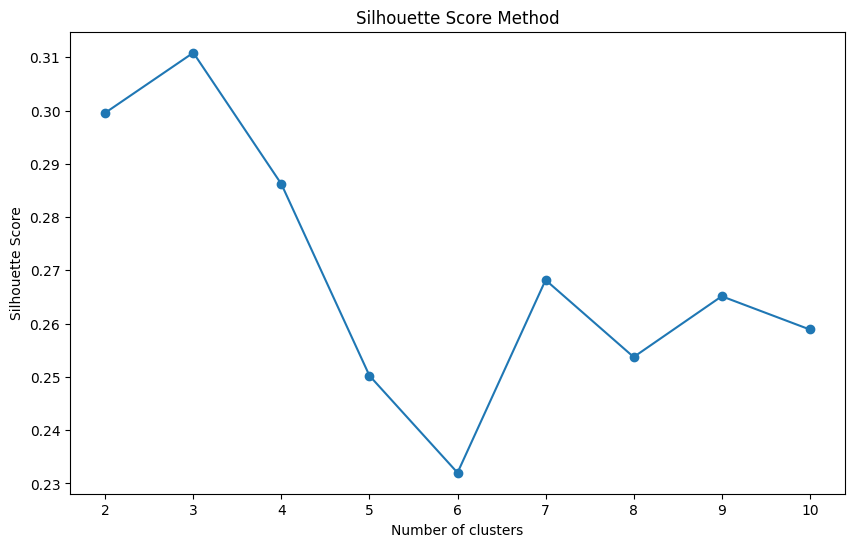

In [7]:
# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
    silhouette_avg = silhouette_score(rfm_scaled[['Recency', 'Frequency', 'Monetary']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Apply K-Means Clustering ###

In [8]:
# Based on the plots, choose optimal number of clusters (e.g., 4)
optimal_clusters = 4

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
rfm_scaled['Cluster'] = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# Merge cluster labels with original RFM data
rfm['Cluster'] = rfm_scaled['Cluster']

print(rfm.head())

  CustomerID  Recency  Frequency  Monetary  Cluster
0   CUST1000        9         41   6855.79        2
1   CUST1001       49         10   2856.43        3
2   CUST1002        7         25   2175.73        0
3   CUST1003       22         33   1085.57        0
4   CUST1004      134         27   6887.81        1


## Step 5: Segment Profiling and Interpretation
### Analyze Cluster Characteristics

            Recency  Frequency     Monetary  Count
Cluster                                           
0         44.883495  27.446602  1738.976311    103
1         87.537736  35.764151  8730.439340    212
2         10.186813  33.780220  8432.536593     91
3        122.840426  17.659574  3640.992234     94


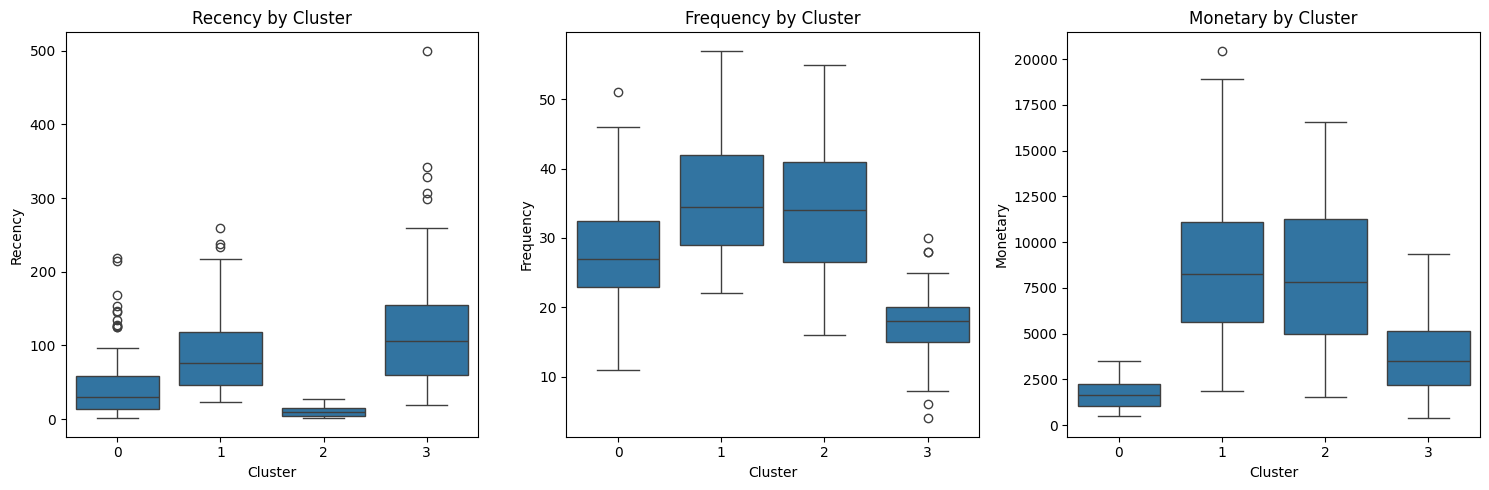

In [9]:
# Calculate average RFM values for each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

print(cluster_summary)

# Visualize clusters
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.title('Recency by Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.title('Frequency by Cluster')

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Monetary by Cluster')

plt.tight_layout()
plt.show()

### Name the Segments
Based on the cluster characteristics, we can assign meaningful names:

- Loyal High Spenders: High frequency and monetary value, recent purchases

- At-Risk High Value: High monetary value but less frequent/recent purchases

- New Customers: Recent purchases but low frequency and monetary value

- Low Engagement: Low on all RFM metrics

In [10]:
# Assign segment names
segment_names = {
    0: 'At-Risk High Value',
    1: 'Low Engagement',
    2: 'Loyal High Spenders',
    3: 'New Customers'
}

rfm['Segment'] = rfm['Cluster'].map(segment_names)
cluster_summary['Segment'] = cluster_summary.index.map(segment_names)

print(cluster_summary)

            Recency  Frequency     Monetary  Count              Segment
Cluster                                                                
0         44.883495  27.446602  1738.976311    103   At-Risk High Value
1         87.537736  35.764151  8730.439340    212       Low Engagement
2         10.186813  33.780220  8432.536593     91  Loyal High Spenders
3        122.840426  17.659574  3640.992234     94        New Customers


### Visualize Segments in 3D Space

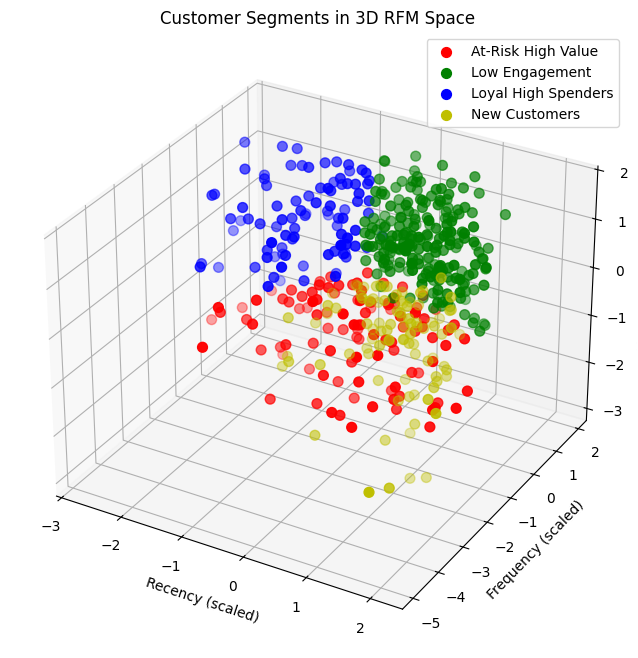

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y']
for i in range(optimal_clusters):
    cluster_data = rfm_scaled[rfm_scaled['Cluster'] == i]
    ax.scatter(cluster_data['Recency'], 
               cluster_data['Frequency'], 
               cluster_data['Monetary'], 
               c=colors[i], 
               label=segment_names[i],
               s=50)

ax.set_xlabel('Recency (scaled)')
ax.set_ylabel('Frequency (scaled)')
ax.set_zlabel('Monetary (scaled)')
ax.set_title('Customer Segments in 3D RFM Space')
plt.legend()
plt.show()

In [12]:
# Save the segmented data for further analysis
rfm.to_csv('customer_segments_rfm.csv', index=False)

## Conclusion and Marketing Recommendations
### Based on the RFM analysis and clustering:

### Loyal High Spenders (Cluster 2):

Strategy: Reward these customers with exclusive offers and loyalty programs

Action: Upsell premium products, offer early access to new products

### At-Risk High Value (Cluster 0):

Strategy: Win-back campaigns to re-engage

Action: Personalized reactivation offers, surveys to understand why they're less active

### New Customers (Cluster 3):

Strategy: Nurture these customers to increase engagement

Action: Welcome series, educational content, small incentives for repeat purchases

### Low Engagement (Cluster 1):

Strategy: Determine if worth retaining or focus on higher-value segments

Action: Low-cost engagement tactics, or consider letting them lapse if not profitable

### Next Steps

- Validate the segments with business stakeholders

- Design targeted marketing campaigns for each segment

- Set up regular RFM analysis to track segment changes over time

- Consider adding additional variables (like product categories) for more sophisticated segmentation

